In [28]:
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score


plt.rcParams['axes.unicode_minus'] = False

def load_and_parse_data(xml_file):
    start_lon, start_lat = 120.00, 21.88
    lon_resolution, lat_resolution = 0.03, 0.03
    lon_count, lat_count = 67, 120
    invalid_value = -999.0
    tree = ET.parse(xml_file)
    root = tree.getroot()
    namespace = {'cwa': 'urn:cwa:gov:tw:cwacommon:0.1'}
    content_str = root.find('.//cwa:Content', namespace).text
    raw_values = []
    lines = content_str.strip().split('\n')
    for line in lines:
        values = [float(v) for v in line.strip().split(',') if v.strip()]
        raw_values.extend(values)
    lons = np.arange(lon_count) * lon_resolution + start_lon
    lats = np.arange(lat_count) * lat_resolution + start_lat
    grid_points = []
    for lat in lats:
        for lon in lons:
            grid_points.append((lon, lat))
    num_expected_points = lon_count * lat_count
    if len(raw_values) != num_expected_points:
        raw_values = (raw_values + [invalid_value] * num_expected_points)[:num_expected_points]
    df = pd.DataFrame(grid_points, columns=['longitude', 'latitude'])
    df['temperature'] = raw_values
    return df

def create_datasets(base_df):
    # Classification
    df_cls = base_df.copy()
    df_cls['label'] = (df_cls['temperature'] != -999.0).astype(int)
    X_cls = df_cls[['longitude', 'latitude']]
    y_cls = df_cls['label']
    
    # Regression
    df_reg = base_df[base_df['temperature'] != -999.0].copy()
    X_reg = df_reg[['longitude', 'latitude']]
    y_reg = df_reg['temperature']
    
    return X_cls, y_cls, X_reg, y_reg


### Explanation of the Combined Model Construction

The goal is to create a composite model, $h(\vec{x})$, whose behavior is defined in two distinct pieces:
1.  The Gatekeeper: For any given input coordinate $\vec{x}$ (longitude and latitude), we first use a pre-trained classification model, $C(\vec{x})$, to determine if the point lies within a "valid region."
2.  Routing the Output:
    *   If the classifier $C(\vec{x})$ predicts `1` (valid), it means the point should have a temperature value. We then pass this coordinate $\vec{x}$ to a pre-trained **regression model, $R(\vec{x})$**, to predict its temperature.
    *   If the classifier $C(\vec{x})$ predicts `0` (invalid), it means the point is in an area with no valid data (e.g., the sea). We directly return the fixed invalid value, `-999`.

In [29]:
def build_combined_model(classifier, regressor):
    """
    Takes a trained classifier and regressor and returns a combined function h(x).
    """
    def h(X):
        """
        The piecewise smooth function h(x).
        X: DataFrame or numpy array with columns ['longitude', 'latitude']
        """
        # Use classifier C(x) to predict validity
        is_valid_pred = classifier.predict(X)
        
        results = np.full(len(X), -999.0)
        valid_indices = np.where(is_valid_pred == 1)[0]
        X_valid = X.iloc[valid_indices] if isinstance(X, pd.DataFrame) else X[valid_indices]
        temp_predictions = regressor.predict(X_valid)
        results[valid_indices] = temp_predictions
            
        return results
    
    return h



--- (A) Classification Performance (Predicting valid/invalid) ---
Accuracy in identifying valid/invalid : 0.9797
report:
              precision    recall  f1-score   support

     Invalid       0.98      0.98      0.98      1372
       Valid       0.98      0.97      0.98      1040

    accuracy                           0.98      2412
   macro avg       0.98      0.98      0.98      2412
weighted avg       0.98      0.98      0.98      2412


--- (B) Regression Performance ---
Samples evaluated: 1012 / 1040
RMSE     : 2.2747 °C
R-squared     : 0.8560


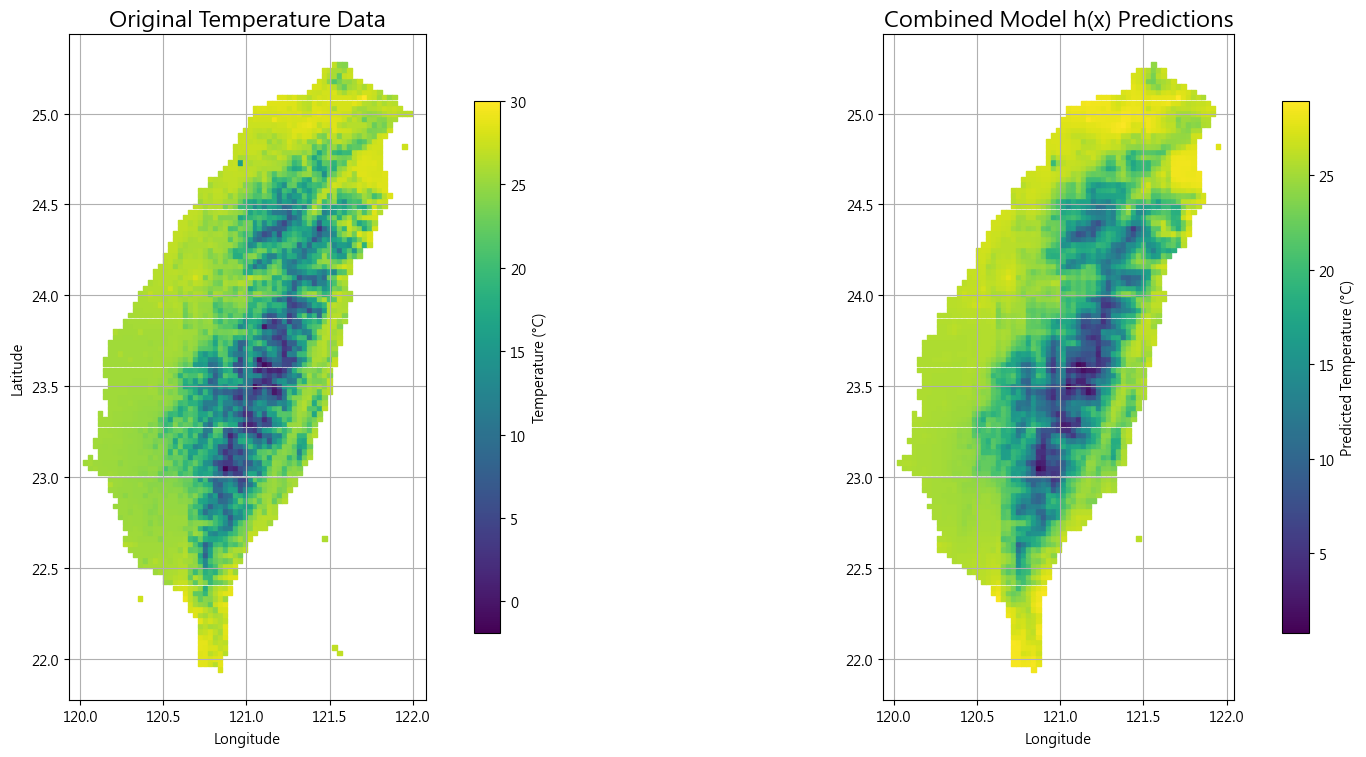

In [30]:
xml_filename = "O-A0038-003.xml"
base_df = load_and_parse_data(xml_filename)

train_df, test_df = train_test_split(base_df, test_size=0.3, random_state=42)

X_cls_train = train_df[['longitude', 'latitude']]
y_cls_train = (train_df['temperature'] != -999.0).astype(int)

reg_train_df = train_df[train_df['temperature'] != -999.0]
X_reg_train = reg_train_df[['longitude', 'latitude']]
y_reg_train = reg_train_df['temperature']

# Train the classification model C(x)
classifier_C = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
classifier_C.fit(X_cls_train, y_cls_train)

# Train the regression model R(x)
regressor_R = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
regressor_R.fit(X_reg_train, y_reg_train)

h_model = build_combined_model(classifier_C, regressor_R)


X_test = test_df[['longitude', 'latitude']]
y_test_true = test_df['temperature'].values

y_h_pred = h_model(X_test)


# (A) evaluation of classification
y_test_true_labels = (y_test_true != -999.0).astype(int)
y_h_pred_labels = (y_h_pred != -999.0).astype(int)

print("\n--- (A) Classification Performance (Predicting valid/invalid) ---")
cls_accuracy = accuracy_score(y_test_true_labels, y_h_pred_labels)
print(f"Accuracy in identifying valid/invalid : {cls_accuracy:.4f}")
print("report:")
print(classification_report(y_test_true_labels, y_h_pred_labels, target_names=['Invalid', 'Valid']))

# (B) evaluation of regression
valid_indices_true = np.where(y_test_true != -999.0)[0]

y_test_true_valid = y_test_true[valid_indices_true]
y_h_pred_valid = y_h_pred[valid_indices_true]

eval_indices = np.where(y_h_pred_valid != -999.0)[0]

y_test_final = y_test_true_valid[eval_indices]
y_pred_final = y_h_pred_valid[eval_indices]

mse = mean_squared_error(y_test_final, y_pred_final)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_final, y_pred_final)

print("\n--- (B) Regression Performance ---")
print(f"Samples evaluated: {len(eval_indices)} / {len(valid_indices_true)}")
print(f"RMSE     : {rmse:.4f} °C")
print(f"R-squared     : {r2:.4f}")

# Visualization
all_grid_points = base_df[['longitude', 'latitude']]
h_predictions_full = h_model(all_grid_points)

h_predictions_plot = h_predictions_full.copy()
h_predictions_plot[h_predictions_plot == -999.0] = np.nan

original_temp_plot = base_df['temperature'].copy()
original_temp_plot[original_temp_plot == -999.0] = np.nan

# Set correct aspect ratio
center_latitude = (base_df['latitude'].min() + base_df['latitude'].max()) / 2
aspect_ratio = 1 / np.cos(np.radians(center_latitude))

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Left plot: Original Temperature Data
scatter1 = axes[0].scatter(base_df['longitude'], base_df['latitude'], c=original_temp_plot, 
                            cmap='viridis', s=10, marker='s')
fig.colorbar(scatter1, ax=axes[0], label='Temperature (°C)', shrink=0.8)
axes[0].set_title('Original Temperature Data', fontsize=16)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].grid(True)
axes[0].set_aspect(aspect_ratio, adjustable='box')

# Right plot: Combined Model h(x) Predictions
scatter2 = axes[1].scatter(base_df['longitude'], base_df['latitude'], c=h_predictions_plot, 
                            cmap='viridis', s=10, marker='s')
fig.colorbar(scatter2, ax=axes[1], label='Predicted Temperature (°C)', shrink=0.8)
axes[1].set_title('Combined Model h(x) Predictions', fontsize=16)
axes[1].set_xlabel('Longitude')
axes[1].grid(True)
axes[1].set_aspect(aspect_ratio, adjustable='box')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()